In [11]:
import os
print(os.path.exists("../data/alzheimer_dataset.csv"))



True


In [12]:
# --- Import libraries ---
from pathlib import Path
import joblib
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)


# --- Build preprocessing + model pipeline ---
def build_pipeline(numeric_cols, categorical_cols):
    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols)
    ], remainder="drop")

    clf = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
    ])
    return clf


# --- Evaluation + saving ---
def evaluate_and_save(model, X_test, y_test, out_dir):
    y_pred = model.predict(X_test)
    metrics = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "precision": float(precision_score(y_test, y_pred, average="binary" if len(np.unique(y_test))==2 else "macro", zero_division=0)),
        "recall": float(recall_score(y_test, y_pred, average="binary" if len(np.unique(y_test))==2 else "macro", zero_division=0)),
        "f1": float(f1_score(y_test, y_pred, average="binary" if len(np.unique(y_test))==2 else "macro", zero_division=0))
    }

    if len(np.unique(y_test)) == 2:
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            metrics["roc_auc"] = float(roc_auc_score(y_test, y_prob))
        except Exception:
            metrics["roc_auc"] = None

    out_dir.mkdir(parents=True, exist_ok=True)
    with open(out_dir / "logistic_metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)

    report = classification_report(y_test, y_pred, zero_division=0)
    with open(out_dir / "classification_report.txt", "w") as f:
        f.write(report)

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, int(v), ha="center", va="center", color="black", fontsize=12)
    fig.colorbar(im)
    plt.tight_layout()
    plt.savefig(out_dir / "confusion_matrix.png", dpi=200)
    plt.close()

    return metrics


# --- Main training function ---
def main(csv_path, target_col, test_size, random_state, save_path):
    csv_path = Path(csv_path)
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    df = pd.read_csv(csv_path)

    drop_cols = [c for c in ["PatientID", "DoctorInCharge"] if c in df.columns]
    df = df.drop(columns=drop_cols, errors="ignore")

    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in CSV columns: {df.columns.tolist()}")

    X = df.drop(columns=[target_col])
    y = df[target_col].copy()

    if y.dtype == object or not np.issubdtype(y.dtype, np.number):
        le = LabelEncoder()
        y = le.fit_transform(y)
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        joblib.dump(le, Path(save_path).parent / "label_encoder_target.joblib")

    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    pipe = build_pipeline(numeric_cols, categorical_cols)

    stratify = y if len(np.unique(y)) > 1 else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify
    )

    param_grid = {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__class_weight": [None, "balanced"]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    gs = GridSearchCV(pipe, param_grid, cv=cv,
                      scoring="f1" if len(np.unique(y))==2 else "accuracy",
                      n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)

    print("Best params:", gs.best_params_)

    best = gs.best_estimator_
    out_dir = Path(save_path).parent
    metrics = evaluate_and_save(best, X_test, y_test, out_dir)

    joblib.dump(best, save_path)
    print(f"Saved trained model to: {save_path}")
    print("Metrics:", metrics)


# --- Direct run (for Jupyter) ---
csv_path = "../data/alzheimer_dataset.csv"
target_col = "Diagnosis"
test_size = 0.2
random_state = 42
save_path = "../outputs/models/logistic_pipeline.joblib"

main(csv_path, target_col, test_size, random_state, save_path)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf__C': 0.01, 'clf__class_weight': 'balanced'}
Saved trained model to: ../outputs/models/logistic_pipeline.joblib
Metrics: {'accuracy': 0.8, 'precision': 0.665, 'recall': 0.875, 'f1': 0.7556818181818182, 'roc_auc': 0.8827858765619084}


In [13]:
import joblib
import pandas as pd

# Load model
model = joblib.load("../outputs/models/logistic_pipeline.joblib")

# Load dataset again for testing
df = pd.read_csv("../data/alzheimer_dataset.csv")

# Prepare input (drop target column)
X = df.drop(columns=["Diagnosis"])

# Predict
preds = model.predict(X)
print(preds[:10])  # show first 10 predictions


[0 0 0 0 1 0 0 1 1 1]


In [14]:
import joblib
import pandas as pd

# Load the saved model
model = joblib.load("../outputs/models/logistic_pipeline.joblib")

# Load dataset again
df = pd.read_csv("../data/alzheimer_dataset.csv")

# Drop the target column for predictions
X = df.drop(columns=["Diagnosis"])

# Make predictions
preds = model.predict(X)

# Show first few predictions
print("Sample predictions:", preds[:10])

# Optionally, attach predictions to the dataframe
df["Predicted_Diagnosis"] = preds
df.head()


Sample predictions: [0 0 0 0 1 0 0 1 1 1]


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge,Predicted_Diagnosis
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,1.725883,0,0,0,1,0,0,XXXConfid,0
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,2.592424,0,0,0,0,1,0,XXXConfid,0
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,7.119548,0,1,0,1,0,0,XXXConfid,0
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,1,6.481226,0,0,0,0,0,0,XXXConfid,0
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0.014691,0,0,1,1,0,0,XXXConfid,1


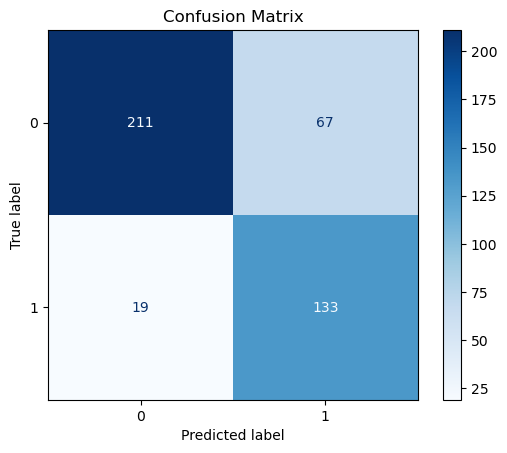

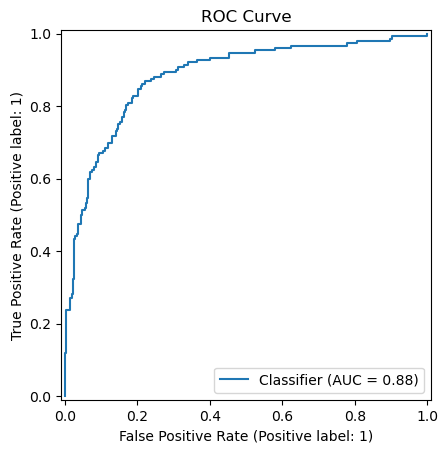

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np

# Reload dataset and split again (same params as before)
X = df.drop(columns=["Diagnosis", "Predicted_Diagnosis"])
y = df["Diagnosis"]

# If your target was encoded, load the encoder
try:
    le = joblib.load("../outputs/models/label_encoder_target.joblib")
    y = le.transform(y)
except:
    pass

# Split into test and train (use same random_state)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Predictions for visualization
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# --- Confusion Matrix ---
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve ---
if len(np.unique(y)) == 2:  # Only for binary problems
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title("ROC Curve")
    plt.show()


In [16]:
df.to_csv("../outputs/models/predictions.csv", index=False)
print("Predictions saved to ../outputs/models/predictions.csv")


Predictions saved to ../outputs/models/predictions.csv


python: can't open file 'C:\\Users\\Isha Singh\\Desktop\\Alzheimer-Prediction-System-main\\notebooks\\predict.py': [Errno 2] No such file or directory
